## EDA

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import folium
import geopandas as gpd
import json
from branca.colormap import linear
from shapely.geometry.polygon import Polygon
from geopy.distance import geodesic
from geographiclib.geodesic import Geodesic

In [2]:
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

In [3]:
df = pd.read_csv('../data/aqi_51state_2003_2019.csv')

In [4]:
df.shape

(57345398, 9)

In [5]:
# Load power plant data
df_pp = pd.read_csv('../data/pp_clean.csv')

In [6]:
df_rv = pd.read_csv('../data/registered_vehicles.csv')
df_acre = pd.read_excel('../data/state_acres.xlsx')
df_lung = pd.read_csv('../data/lung_cancer.csv')

In [21]:
df_all = pd.read_csv('../data/air/airdata_cleaned/co_aq_2019_null.csv')
df_all = pd.concat([df_all, pd.read_csv('../data/air/airdata_cleaned/no2_aq_2019_null.csv')], axis=0)
df_all = pd.concat([df_all, pd.read_csv('../data/air/airdata_cleaned/oz_aq_2019_null.csv')], axis=0)
df_all = pd.concat([df_all, pd.read_csv('../data/air/airdata_cleaned/pm10_aq_2019_null.csv')], axis=0)
df_all = pd.concat([df_all, pd.read_csv('../data/air/airdata_cleaned/pm25_aq_2019_null.csv')], axis=0)
df_all = pd.concat([df_all, pd.read_csv('../data/air/airdata_cleaned/so2_aq_2019_null.csv')], axis=0)

In [22]:
df_all.head(1)

type  aqi      mean  max    state    id        date        lat    long
0   co  NaN  0.041667  0.2  Alabama  1003  2019-01-01  33.485556 -86.915

In [27]:
df_type_aqi = df_all.dropna().pivot_table(index=['type'], values=['aqi'], aggfunc='mean')

In [29]:
df_type_aqi

aqi
type            
co      4.090818
no2    15.042584
ozone  39.879138
pm10   16.550137
pm2_5  29.515793
so2     3.643289

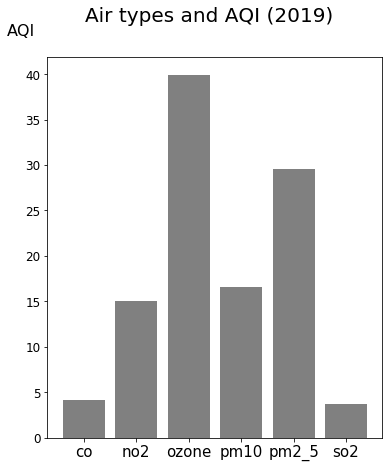

In [39]:
fig = plt.figure(figsize=(6, 7))
plt.bar(df_type_aqi.index, df_type_aqi['aqi'], color='gray')
fig.suptitle('Air types and AQI (2019)', fontsize=20)
plt.ylabel('AQI', fontsize=16, rotation=0, position=(0,1.05))
plt.xticks(fontsize=15)
plt.yticks(fontsize=12);

### Trend

In [7]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month

In [8]:
df.head(2)

aqi       date    id        lat    long  max      mean    state type  year  \
0  NaN 2019-01-01  1003  33.485556 -86.915  0.2  0.041667  Alabama   co  2019   
1  NaN 2019-01-02  1003  33.485556 -86.915  0.2  0.091667  Alabama   co  2019   

   month  
0      1  
1      1

Dataframes with Air Quality Index(AQI)

In [9]:
piv_aqi = df.dropna().pivot_table(index=['year', 'state', 'lat', 'long', 'type'], values=['aqi'], aggfunc='mean')
piv_aqi.reset_index(level=['year', 'state', 'lat', 'long', 'type'], inplace=True)

In [10]:
piv_aqi.head(2)

year    state        lat       long   type        aqi
0  2003  Alabama  30.474305 -88.141022  ozone  48.792717
1  2003  Alabama  30.474305 -88.141022   pm10  16.310345

In [11]:
piv_aqi_month = df.dropna().pivot_table(index=['year', 'month', 'state', 'lat', 'long', 'type'], values=['aqi'], aggfunc='mean')
piv_aqi_month.reset_index(level=['year', 'month', 'state', 'lat', 'long', 'type'], inplace=True)

In [12]:
piv_aqi_month['date'] = piv_aqi_month['year'].map(str)+ '-' +piv_aqi_month['month'].map(str)
piv_aqi_month['date'] = pd.to_datetime(piv_aqi_month['date'], format='%Y-%m').dt.strftime('%Y-%m')

In [13]:
piv_aqi_month.head(2)

year  month    state        lat       long   type   aqi     date
0  2003      1  Alabama  30.474305 -88.141022   pm10  15.0  2003-01
1  2003      1  Alabama  30.474305 -88.141022  pm2_5  45.3  2003-01

In [14]:
aqi_month_stt = df.dropna().pivot_table(index=['year', 'month', 'state', 'type'], values=['aqi'], aggfunc='mean')
aqi_month_stt.reset_index(level=['year', 'month', 'state', 'type'], inplace=True)
aqi_month_stt.head(2)

year  month    state type        aqi
0  2003      1  Alabama   co   8.741935
1  2003      1  Alabama  no2  16.000000

In [48]:
aqi_month_stt.tail()

year  month    state   type        aqi
52313  2019     12  Wyoming     co   1.000000
52314  2019     12  Wyoming    no2   6.774194
52315  2019     12  Wyoming  ozone  38.983696
52316  2019     12  Wyoming   pm10   7.537155
52317  2019     12  Wyoming    so2   1.275986

In [15]:
aqi_year_stt = df.dropna().pivot_table(index=['year', 'state', 'type'], values=['aqi'], aggfunc='mean')
aqi_year_stt.reset_index(level=['year', 'state', 'type'], inplace=True)
aqi_year_stt.head(2)

year    state type        aqi
0  2003  Alabama   co   8.798648
1  2003  Alabama  no2  12.743662

In [16]:
# avg aqi pm2.5 by state 2019
aqi_year_stt[['state', 'aqi']][(aqi_year_stt['year'] == 2019) & (aqi_year_stt['type'] == 'pm2_5')].sort_values(by='aqi', ascending=False)

state        aqi
4799               Georgia  37.320868
4740               Alabama  36.318116
4817              Illinois  35.893172
4883           Mississippi  35.665475
4948                  Ohio  35.644599
4823               Indiana  35.317011
4758              Arkansas  35.301587
4966          Pennsylvania  35.012357
4996                 Texas  34.922466
4847             Louisiana  34.462083
4954              Oklahoma  34.367374
4841              Kentucky  34.059096
4787  District Of Columbia  33.754522
4871              Michigan  32.986677
4918            New Jersey  32.965211
5025         West Virginia  32.865546
4889              Missouri  32.760896
4990             Tennessee  31.867352
4829                  Iowa  31.847888
4936        North Carolina  31.807636
4978        South Carolina  30.830033
4746                Alaska  30.772918
4835                Kansas  30.752629
4781              Delaware  30.557585
4793               Florida  30.136621
5014              Virginia  29.421085
4764            California  29.415637
4776           Connecticut  28.726464
5031             Wisconsin  28.490601
4960                Oregon  28.054176
4859              Maryland  27.827082
4770              Colorado  27.409422
4900              Nebraska  27.348292
4930              New York  27.209918
4865         Massachusetts  26.380153
4752               Arizona  26.071041
5020            Washington  24.812807
4877             Minnesota  24.807903
5002                  Utah  24.511774
4924            New Mexico  24.326717
5008               Vermont  24.210439
4811                 Idaho  23.249827
4895               Montana  23.140971
4972          Rhode Island  22.501238
4906                Nevada  22.213084
4853                 Maine  20.754942
4984          South Dakota  20.128007
4912         New Hampshire  19.302419
4942          North Dakota  19.010707
5037               Wyoming  13.028209
4805                Hawaii  12.710409

In [17]:
# avg aqi pm2.5 by state 2003
aqi_year_stt[['state', 'aqi']][(aqi_year_stt['year'] == 2003) & (aqi_year_stt['type'] == 'pm2_5')].sort_values(by='aqi', ascending=False)

state        aqi
209                  Ohio  54.397482
62                Georgia  53.552855
286         West Virginia  53.454940
86                Indiana  53.090788
227          Pennsylvania  52.167517
50   District Of Columbia  52.160822
104              Kentucky  52.000348
4                 Alabama  51.951200
80               Illinois  51.896351
250             Tennessee  51.658869
121              Maryland  51.157556
44               Delaware  50.164047
26             California  49.300281
180            New Jersey  49.147959
133              Michigan  48.612743
151              Missouri  48.552409
198        North Carolina  48.388205
274              Virginia  48.322829
145           Mississippi  47.867647
38            Connecticut  47.547651
239        South Carolina  46.868652
20               Arkansas  45.997183
110             Louisiana  45.234507
192              New York  45.163012
256                 Texas  44.351160
98                 Kansas  43.381761
127         Massachusetts  42.847638
92                   Iowa  41.943862
233          Rhode Island  41.826804
215              Oklahoma  41.773229
292             Wisconsin  41.456735
157               Montana  39.639874
162              Nebraska  37.165165
268               Vermont  36.364130
139             Minnesota  36.095063
174         New Hampshire  36.077148
56                Florida  36.053313
280            Washington  33.617910
262                  Utah  33.534144
221                Oregon  33.234043
244          South Dakota  32.961274
32               Colorado  32.896321
14                Arizona  32.371991
168                Nevada  31.789374
186            New Mexico  29.783784
74                  Idaho  28.961982
203          North Dakota  27.565495
298               Wyoming  27.341000
9                  Alaska  24.661176
68                 Hawaii  18.626159

In [18]:
# avg aqi ozone by state 2019
aqi_year_stt[['state', 'aqi']][(aqi_year_stt['year'] == 2019) & (aqi_year_stt['type'] == 'ozone')].sort_values(by='aqi', ascending=False)

state        aqi
4922            New Mexico  49.022079
4750               Arizona  47.054842
4768              Colorado  45.722382
5035               Wyoming  44.197719
5000                  Utah  44.079600
4904                Nevada  43.985640
4762            California  43.846660
4774           Connecticut  43.492317
4857              Maryland  43.211863
4988             Tennessee  42.168118
4976        South Carolina  42.005270
4934        North Carolina  41.935317
4970          Rhode Island  41.646045
4946                  Ohio  41.124635
4797               Georgia  40.990970
5012              Virginia  40.808079
4982          South Dakota  40.733503
4839              Kentucky  40.708559
4815              Illinois  39.982836
4916            New Jersey  39.949262
4738               Alabama  39.744314
4887              Missouri  39.594134
5023         West Virginia  38.555870
4952              Oklahoma  38.308528
4869              Michigan  38.205328
4780              Delaware  37.969940
4994                 Texas  37.831554
4881           Mississippi  37.269427
4785  District Of Columbia  37.124726
5029             Wisconsin  36.527270
4928              New York  36.047665
4964          Pennsylvania  35.889645
4893               Montana  35.863896
4791               Florida  35.803010
4827                  Iowa  35.787094
5006               Vermont  35.772803
4756              Arkansas  35.662928
4863         Massachusetts  35.571613
4821               Indiana  35.393311
4809                 Idaho  35.313653
4833                Kansas  35.067012
4875             Minnesota  35.042111
4898              Nebraska  34.792957
4910         New Hampshire  34.722827
4845             Louisiana  34.663716
4851                 Maine  34.123091
4940          North Dakota  33.455226
5018            Washington  32.569511
4958                Oregon  32.369029
4744                Alaska  29.622249
4803                Hawaii  25.916667

In [19]:
# avg aqi ozone by state 2003
aqi_year_stt[['state', 'aqi']][(aqi_year_stt['year'] == 2003) & (aqi_year_stt['type'] == 'ozone')].sort_values(by='aqi', ascending=False)

state        aqi
260                  Utah  67.688889
24             California  55.474801
12                Arizona  54.173650
296               Wyoming  53.561369
84                Indiana  53.206009
149              Missouri  52.292199
231          Rhode Island  52.178523
196        North Carolina  50.388363
184            New Mexico  49.798825
207                  Ohio  48.976968
248             Tennessee  48.962620
290             Wisconsin  48.227715
72                  Idaho  47.833105
131              Michigan  47.810341
36            Connecticut  47.752555
166                Nevada  47.455271
119              Maryland  47.224030
60                Georgia  46.894205
272              Virginia  46.839110
213              Oklahoma  46.817965
30               Colorado  46.654950
242          South Dakota  46.585366
102              Kentucky  46.484424
143           Mississippi  46.364479
42               Delaware  44.265994
2                 Alabama  44.263693
225          Pennsylvania  44.142640
125         Massachusetts  43.926685
137             Minnesota  43.891249
90                   Iowa  43.757986
254                 Texas  43.513099
96                 Kansas  43.501852
284         West Virginia  43.093717
237        South Carolina  43.052232
178            New Jersey  42.343616
172         New Hampshire  41.761787
108             Louisiana  41.405382
219                Oregon  41.188302
18               Arkansas  39.821263
190              New York  39.819699
114                 Maine  38.798191
78               Illinois  38.240481
278            Washington  38.003885
266               Vermont  37.580889
54                Florida  36.945908
160              Nebraska  36.477535
201          North Dakota  36.297480
155               Montana  34.267821
48   District Of Columbia  33.808810
7                  Alaska  33.667283
66                 Hawaii  21.966094

Mean value of air data

In [72]:
piv = df.pivot_table(index=['year', 'state', 'lat', 'long', 'type'], values=['mean'], aggfunc='median')
piv.reset_index(level=['year', 'state', 'lat', 'long', 'type'], inplace=True)
piv.head(2)

year    state        lat       long   type    mean
0  2003  Alabama  30.474305 -88.141022  ozone   0.029
1  2003  Alabama  30.474305 -88.141022   pm10  16.500

In [21]:
piv.tail(2)

year    state        lat        long   type      mean
69655  2019  Wyoming  44.815142 -106.955933  pm2_5  4.250000
69656  2019  Wyoming  44.933611 -106.847222  ozone  0.037588

Making plots for trend

In [43]:
aqi_oz = aqi_month_stt[aqi_month_stt['type'] == 'ozone']
aqi_pm25 = aqi_month_stt[aqi_month_stt['type'] == 'pm2_5']
aqi_oz.sort_values(by=['month'], inplace=True)
aqi_pm25.sort_values(by=['month'], inplace=True)

C:\Users\jjing\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jjing\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [44]:
aqi_oz['date'] = aqi_oz['year'].map(str)+ '-' +aqi_oz['month'].map(str)
aqi_oz['date'] = pd.to_datetime(aqi_oz['date'], format='%Y-%m').dt.strftime('%Y-%m')
aqi_pm25['date'] = aqi_pm25['year'].map(str)+ '-' +aqi_pm25['month'].map(str)
aqi_pm25['date'] = pd.to_datetime(aqi_pm25['date'], format='%Y-%m').dt.strftime('%Y-%m')

C:\Users\jjing\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\jjing\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jjing\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [24]:
# import matplotlib.dates as mdates

In [25]:
# plt_years = mdates.YearLocator() 

In [56]:
years = [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003]
colors = {2019:'#ff0000', 2018:'#FB046C', 2017:'#4B0082', 2016:'#800080', 2015:'#9932CC', 2014:'#9370DB', 2013:'#FF00FF',
          2012:'#191970', 2011:'#0000FF', 2010:'#5F9EA0', 2009:'#1E90FF', 2008:'#00BFFF',
          2007:'#666600', 2006:'#00FFFF', 2005:'#FF6347', 2004:'#808080', 2003:'#B0E0E6'}
states = aqi_oz.sort_values(by=['state'])['state'].unique()

In [55]:
aqi_oz.pivot_table(index=['year', 'month'], values=['aqi'], aggfunc='mean')

aqi
year month           
2003 1      27.086870
     2      29.995679
     3      38.185437
     4      50.397284
     5      45.932235
     6      57.104301
     7      55.565216
     8      52.783687
     9      41.886840
     10     34.437851
     11     28.113197
     12     25.824963
2004 1      27.272791
     2      33.764139
     3      39.856527
     4      48.364580
     5      46.401529
     6      45.404386
     7      48.313094
     8      44.009927
     9      41.041668
     10     29.441257
     11     25.205363
     12     25.392460
2005 1      25.909794
     2      30.873856
     3      39.818766
     4      51.029337
     5      49.460502
     6      55.664971
     7      54.149516
     8      51.624606
     9      47.909776
     10     32.561360
     11     29.053165
     12     24.504280
2006 1      27.855611
     2      33.320017
     3      40.938676
     4      48.749373
     5      50.174134
     6      58.396673
     7      57.588240
     8      51.701261
     9      37.831853
     10     31.531606
     11     27.113698
     12     25.219015
2007 1      26.310804
     2      32.233269
     3      39.933861
     4      46.618530
     5      55.665007
     6      54.408207
     7      49.485074
     8      54.113996
     9      45.385994
     10     33.307141
     11     28.531710
     12     26.252925
2008 1      27.861821
     2      32.668885
     3      40.299951
     4      48.375596
     5      47.862263
     6      50.274277
     7      52.209286
     8      43.086297
     9      37.283180
     10     31.892721
     11     27.498547
     12     25.270845
2009 1      28.235328
     2      34.379578
     3      39.283580
     4      46.290902
     5      43.368152
     6      43.460949
     7      41.955275
     8      40.846126
     9      35.766134
     10     25.854877
     11     28.524329
     12     26.791228
2010 1      29.388498
     2      31.889665
     3      41.338320
     4      46.304676
     5      48.009103
     6      54.649267
     7      61.409716
     8      58.969329
     9      61.586140
     10     39.311678
     11     31.664347
     12     24.904823
2011 1      30.017655
     2      35.375752
     3      38.811289
     4      45.422520
     5      53.211790
     6      56.008538
     7      56.654514
     8      62.667772
     9      61.611069
2012 1      27.984594
     2      33.648412
     3      39.684981
     4      47.498677
     5      62.195129
     6      57.568498
     7      62.481404
     8      65.493847
     9      60.399008
     10     43.624560
     11     31.462170
     12     27.439864
2013 1      29.030660
     2      34.638905
     3      40.990429
     4      44.107245
     5      44.812223
     6      43.120841
     7      42.489846
     8      40.961533
     9      39.011517
     10     30.715315
     11     27.679372
     12     26.058841
2014 1      29.403014
     2      33.279852
     3      38.838562
     4      45.126834
     5      45.451547
     6      41.655841
     7      41.547095
     8      40.565048
     9      34.901342
     10     31.768169
     11     29.305789
     12     23.759946
2015 1      27.787090
     2      32.213855
     3      37.697228
     4      42.034913
     5      45.977220
     6      43.408982
     7      40.809634
     8      42.620636
     9      39.941647
     10     31.261309
     11     28.557281
     12     25.795095
2016 1      29.488137
     2      33.877237
     3      37.602830
     4      43.474105
     5      44.933381
     6      46.884472
     7      42.141992
     8      38.912583
     9      35.708615
     10     32.754942
     11     30.211714
     12     26.783806
2017 1      29.293820
     2      35.374767
     3      38.717637
     4      42.844354
     5      43.739405
     6      44.772684
     7      42.661552
     8      39.865764
     9      37.746145
     10     33.061274
     11     28.302124
     12     27.525748
2018 1      29.668195
     2      31.631098
     3      39.520230
     4      45

In [1]:
for state in states:
    fig = plt.figure(figsize=(14,7))
    fig.suptitle(state + "- Ozone seasonality", fontsize=20)
    plt.ylim(0, 95)    
    data = aqi_oz[(aqi_oz['state'] == state)]
    
    for year in years:
        dt_state = data[(data['year'] == year)]
        plt.plot(dt_state['month'], dt_state['aqi'], color=colors[year])
    plt.legend(years, loc='upper right')
#     break
#     fig.savefig('../img/ozone_seasonality_stack_' + state + '.png')

In [2]:
for state in states:
    fig = plt.figure(figsize=(14,7))
    fig.suptitle(state + "- PM 2.5 seasonality", fontsize=20)
    data = aqi_pm25[(aqi_pm25['state'] == state)]
    plt.ylim(0, 100)
    
    for year in years:
        dt_state = data[(data['year'] == year)]
        plt.plot(dt_state['month'], dt_state['aqi'], color=colors[year])
    plt.legend(years, loc='upper right')

#     fig.savefig('../img/pm2_5_seasonality_stack_' + state + '.png')

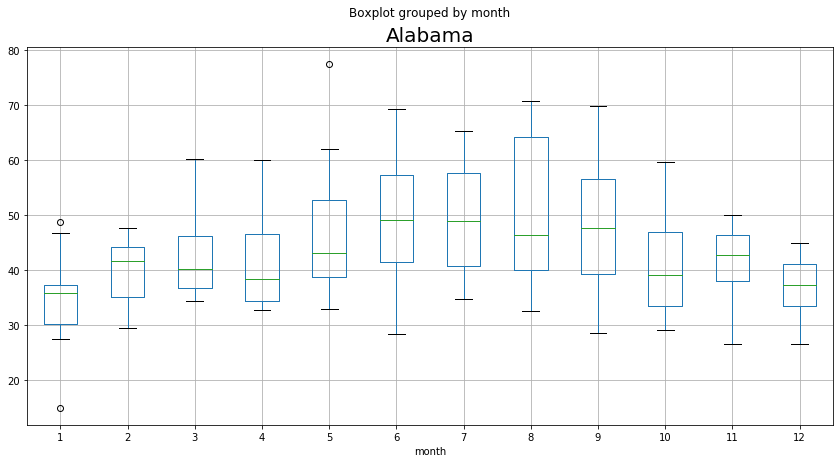

In [333]:
for state in states:
    ax = data.boxplot(column='aqi', by='month', figsize=(14,7))
    ax.set_title(state, fontsize=20)
    break

In [56]:
data.shape

(170, 6)

In [113]:
# Code modified from code written by Matthew Garton.

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
    
    # Set figure size to be (18, 9).
    fig = plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
            
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col])
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.yticks(fontsize=18)
    plt.xticks(df.index[0::steps], fontsize=18);
    
    return fig

In [5]:
for state in states:
    data = aqi_oz[(aqi_oz['state'] == state)]
    data.set_index('date', inplace=True)
    data.sort_index(inplace=True)
    
    fig = plot_series(data, ['aqi'], title='Trend of Ozone AQI in '+ state, steps=6)
    plt.ylim(0, 100)
    plt.xticks(rotation=90)
    plt.grid()
    
#     break
#     fig.savefig('../img/ozone_trend_' + state + '.png')

In [6]:
for state in states:
    data = aqi_oz[(aqi_oz['state'] == state) & (aqi_oz['year'] >= 2013)]
    data.set_index('date', inplace=True)
    data.sort_index(inplace=True)
    
    fig = plot_series(data, ['aqi'], title='Trend of Ozone AQI in '+ state, steps=6)
    plt.ylim(0, 100)
    plt.xticks(rotation=90)
    plt.grid()
    
    break
#     fig.savefig('../img/ozone_seasonality_' + state + '.png')

In [7]:
for state in states:
    data = aqi_pm25[(aqi_pm25['state'] == state)]
    data.set_index('date', inplace=True)
    data.sort_index(inplace=True)
    
    fig = plot_series(data, ['aqi'], title='Trend of PM 2.5 AQI in '+ state, steps=6)
    plt.ylim(0, 100)
    plt.xticks(rotation=90)
    plt.grid()
    
    break
#     fig.savefig('../img/pm2_5_trend_' + state + '.png')

In [8]:
for state in states:
    data = aqi_pm25[(aqi_pm25['state'] == state) & (aqi_pm25['year'] >= 2013)]
    data.set_index('date', inplace=True)
    data.sort_index(inplace=True)
    
    fig = plot_series(data, ['aqi'], title='Trend of PM 2.5 AQI in '+ state, steps=6)
    plt.ylim(0, 100)
    plt.xticks(rotation=90)
    plt.grid()
    
    break
#     fig.savefig('../img/pm2_5_seasonality_' + state + '.png')

In [20]:
df_rv['year'].value_counts()

2017    51
2016    51
2015    51
2014    51
2013    51
2012    51
2011    51
2010    51
2009    51
2008    51
2007    51
2006    51
2005    51
2004    51
2003    51
Name: year, dtype: int64

In [127]:
df_rv.columns

Index(['year', 'state', 'automobile', 'bus', 'truck', 'motorcycle', 'all_mv'], dtype='object')

In [91]:
bar_rv = df_rv.pivot_table(index=['year'], values=['automobile', 'bus', 'truck', 'motorcycle'], aggfunc='sum')
bar_rv.reset_index(level=['year'], inplace=True)

In [92]:
bar_rv.head(1)

year  automobile       bus  motorcycle     truck
0  2003   135669897  776550.0   5370035.0  94943551

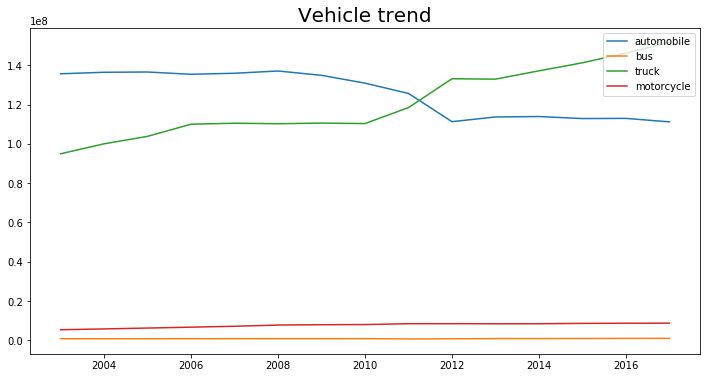

In [103]:
# state = 'Utah'
# data_rv = df_rv[df_rv['state'] == state]
# data_rv.set_index('year', inplace=True)

fig = plt.figure(figsize=(12,6))
plt.title('Vehicle trend', fontsize=20)
# for col in ['automobile', 'bus', 'truck', 'motorcycle']:
plt.plot(bar_rv['year'], bar_rv[['automobile', 'bus', 'truck', 'motorcycle']])
plt.legend(bar_rv[['automobile', 'bus', 'truck', 'motorcycle']], loc='upper right')

In [125]:
data_rv.shape

(15, 6)

In [51]:
aqi_pm25.head(1)

year  month    state   type        aqi     date
4  2003      1  Alabama  pm2_5  43.326984  01-2003

In [104]:
df_pp['year'].value_counts()

2018    10940
2016     9679
2014     8480
2012     7261
2010     5587
2009     5492
2007     5172
2005     4998
2004     4841
Name: year, dtype: int64

In [302]:
df_pp['fuel'][df_pp['boiler'] > 0].value_counts().sort_index()

Biomass        2939
Fossil_fuel    4634
Gas            8583
Hydro          1568
Nuclear         197
Oil            1588
Sun            3553
Wind           1359
Name: fuel, dtype: int64

In [301]:
df_pp['fuel'][df_pp['num_gen'] > 0].value_counts().sort_index()

Biomass         6873
Fossil_fuel     5143
Gas            14741
Hydro          12692
Nuclear          554
Oil             7611
Sun             8215
Wind            6260
Name: fuel, dtype: int64

In [66]:
df_pp.head(1)

year                       name        lat        long  boiler  num_gen  \
0  2018  7-Mile Ridge Wind Project  63.210689 -143.247156     1.0      1.0   

    state  fuel  
0  Alaska  Wind

pm2.5 plots of yearly change

In [64]:
years = [2018, 2016, 2014, 2012, 2010, 2009, 2007, 2005, 2004]

In [68]:
df_pp[df_pp['year'] == 2018].pivot_table(index=['lat', 'long'], values=['boiler'], aggfunc='sum').shape

(10784, 1)

In [74]:
piv[(piv['year']==2018) & (piv['type']=='ozone')].pivot_table(index=['lat', 'long'], values=['mean'], aggfunc='sum').shape

(1278, 1)

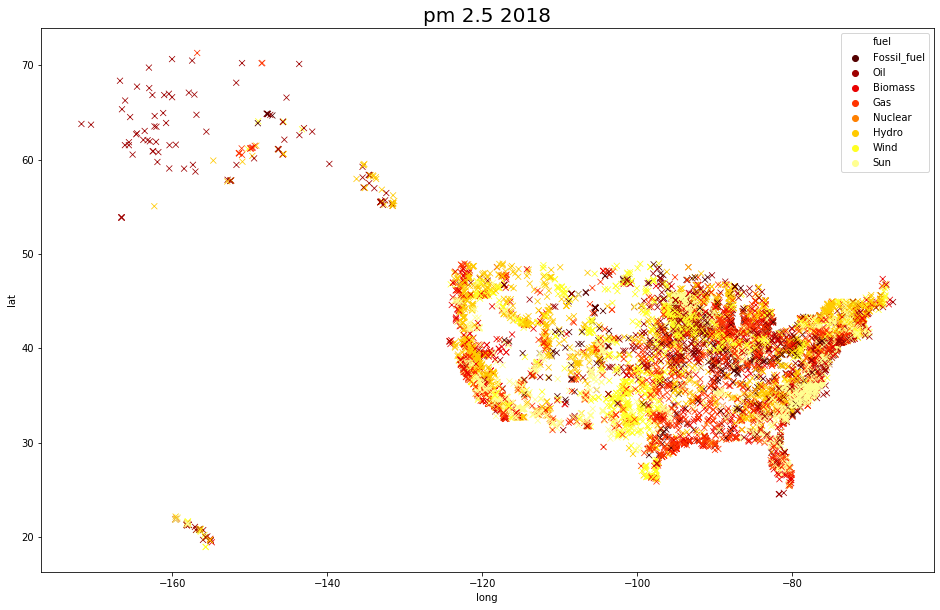

In [65]:
for year in years:
    pp_year = df_pp[df_pp['year'] == year]
    pm25_year = piv_aqi[(piv_aqi['type'] == 'pm2_5') & (piv_aqi['year'] == year)]
    
    fig = plt.figure(figsize=(16, 10))
    ax = sns.scatterplot(x='long', y='lat', hue='fuel',
                         hue_order=['Fossil_fuel', 'Oil', 'Biomass', 'Gas', 'Nuclear', 'Hydro', 'Wind', 'Sun'],
                         data=pp_year, palette="hot", marker="x")
#     ax = sns.scatterplot(x='long', y='lat', hue='aqi', data=pm25_year, palette="winter_r", size='aqi')
    ax.set_title('pm 2.5 ' + str(year), fontsize=20)
    break

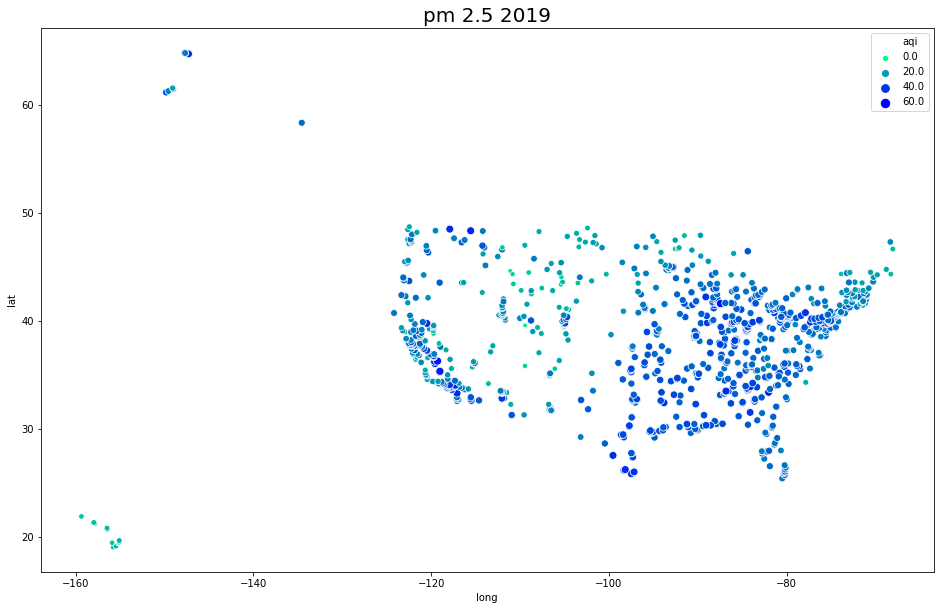

In [60]:
for year in years:
    pp_year = df_pp[df_pp['year'] == year]
    pm25_year = piv_aqi[(piv_aqi['type'] == 'pm2_5') & (piv_aqi['year'] == year)]
    
    fig = plt.figure(figsize=(16, 10))
#     ax = sns.scatterplot(x='long', y='lat', hue='fuel',
#                          hue_order=['Fossil_fuel', 'Oil', 'Biomass', 'Gas', 'Nuclear', 'Hydro', 'Wind', 'Sun'],
#                          data=pp_year, palette="hot", marker="x")
    ax = sns.scatterplot(x='long', y='lat', hue='aqi', data=pm25_year, palette="winter_r", size='aqi')
    ax.set_title('pm 2.5 ' + str(year), fontsize=20)
    break
#     fig.savefig('../img/pm25_' + str(year) + '.png')
    

In [9]:
for year in years:
    pp_year = df_pp[df_pp['year'] == year]
    pm25_year = piv_aqi[(piv_aqi['type'] == 'pm2_5') & (piv_aqi['year'] == year)]
    
    fig = plt.figure(figsize=(16, 10))
    ax = sns.scatterplot(x='long', y='lat', hue='fuel',
                         hue_order=['Fossil_fuel', 'Oil', 'Biomass', 'Gas', 'Nuclear', 'Hydro', 'Wind', 'Sun'],
                         data=pp_year, palette="hot", marker="x")
    ax = sns.scatterplot(x='long', y='lat', hue='aqi', data=pm25_year, palette="winter_r", size='aqi')
    ax.set_title('pm 2.5 ' + str(year), fontsize=20)
    break
#     fig.savefig('../img/pm25_' + str(year) + '.png')
    

In [10]:
for year in years:
    pp_year = df_pp[df_pp['year'] == year]
    pm25_year = piv_aqi[(piv_aqi['type'] == 'ozone') & (piv['year'] == year)]
    
    fig = plt.figure(figsize=(16, 10))
    ax = sns.scatterplot(x='long', y='lat', hue='fuel',
                         hue_order=['Fossil_fuel', 'Oil', 'Biomass', 'Gas', 'Nuclear', 'Hydro', 'Wind', 'Sun'],
                         data=pp_year, palette="hot", marker="x")
    ax = sns.scatterplot(x='long', y='lat', hue='aqi', data=pm25_year, palette="winter_r", size='aqi')
    ax.set_title('Ozone ' + str(year), fontsize=20)
    break
#     fig.savefig('../img/pm25_' + str(year) + '.png')

### Modeling data

In [16]:
air_type = 'ozone'
year = 2016

pp_year = df_pp[df_pp['year'] == year]
air_year = piv_aqi[(piv_aqi['type'] == air_type) & (piv_aqi['year'] == year)]

In [17]:
pp_year.head(2)

year                              name        lat        long  boiler  \
10940  2016         7-Mile Ridge Wind Project  63.210689 -143.247156     0.0   
10941  2016  Agrium Kenai Nitrogen Operations  60.673200 -151.378400     0.0   

       num_gen   state  fuel  
10940      2.0  Alaska  Wind  
10941      5.0  Alaska   Gas

In [18]:
pp_year.shape

(9679, 8)

In [19]:
pp_year.pivot_table(index=['year', 'state', 'lat', 'long', 'fuel'], values=['boiler'], aggfunc='sum').shape

(9554, 1)

In [144]:
def get_direction(lat1, lat2, long1, long2):
    direction = ''
    x = long1 - long2
    y = lat1 - lat2
    
    if ((x==0) & (y<0)):
        direction = 'N'
    elif((x==0) & (y>0)): 
        direction = 'S'
    elif((x<0) & (y==0)):
        direction = 'E'
    elif((x>0) & (y==0)):
        direction = 'W'
    elif ((x<0) & (y<0)):
        direction = 'NE'
    elif((x>0) & (y<0)): 
        direction = 'NW'
    elif ((x<0) & (y>0)):
        direction = 'SE'
    elif((x>0) & (y>0)): 
        direction = 'SW'
        
    return direction

In [145]:
def get_df_distance(air_data, pp_data, date_column):
    air_pp_rel = pd.DataFrame()
    date = []
    air_lat = []
    air_long = []
    air_type = []
    aqi = []
    pp_lat = []
    pp_long = []
    pp_boiler = []
    fuel = []
    distance = []
    direction = []
    state = []

    for i, air_point in air_data.iterrows():
        for j, pp_point in pp_data.iterrows():
            lat1 = air_point['lat']
            long1 = air_point['long']
            lat2 = pp_point['lat']
            long2 = pp_point['long']
            
            date.append(air_point[date_column])
            air_lat.append(lat1)
            air_long.append(long1)
            air_type.append(air_point['type'])
            aqi.append(air_point['aqi'])
            pp_lat.append(lat2)
            pp_long.append(long2)
            pp_boiler.append(pp_point['boiler'])
            fuel.append(pp_point['fuel'])
            state.append(pp_point['state'])
            distance.append(geodesic((lat1, long1), (lat2, long2)).miles)
            direction.append(get_direction(lat1, lat2, long1, long2))
            
    air_pp_rel[date_column] = date
    air_pp_rel['air_lat'] = air_lat
    air_pp_rel['air_long'] = air_long
    air_pp_rel['air_type'] = air_type
    air_pp_rel['aqi'] = aqi
    air_pp_rel['pp_lat'] = pp_lat
    air_pp_rel['pp_long'] = pp_long
    air_pp_rel['pp_boiler'] = pp_boiler
    air_pp_rel['fuel'] = fuel
    air_pp_rel['distance'] = distance
    air_pp_rel['dir'] = direction
    air_pp_rel['state'] = state

    return air_pp_rel

In [146]:
pp_bad = df_pp[df_pp['fuel'].isin(['Fossil_fuel', 'Oil', 'Biomass', 'Gas'])]

In [308]:
# years = [2018, 2016, 2014, 2012, 2010, 2009, 2007, 2005, 2004] # pp_bad['year'].unique()
# air_types = ['ozone', 'pm2_5']
# pp_states = ['Indiana', 'Illinois', 'Kentucky', 'Ohio', 'Michigan', 'Wisconsin']

# df_air_pp = pd.DataFrame()

# for air_type in air_types:
#     for year in years:
#         air_year = piv_aqi[(piv_aqi['type'] == air_type) & (piv_aqi['year'] == year)]
#         pp_year = pp_bad[pp_bad['year'] == year]
        
#         air_state = air_year[air_year['state'] == 'Indiana']
#         pp_state = pp_year[pp_year['state'].isin(pp_states)]
#         df_air_pp = pd.concat([df_air_pp, get_df_distance(air_state, pp_state, 'year')], axis=0)
# #         get_df_distance(air_state.head(10), pp_state.head(10))
        

In [361]:
# df_air_pp.to_csv('../data/air_pp_Indiana.csv', index=False)

In [39]:
years = [2018, 2016, 2014, 2012, 2010, 2009, 2007, 2005, 2004] # pp_bad['year'].unique()
air_types = ['ozone', 'pm2_5']
pp_states = ['Indiana', 'Illinois', 'Kentucky', 'Ohio', 'Michigan', 'Wisconsin']

df_air_pp_mth = pd.DataFrame()

for air_type in air_types:
    for year in years:
        air_year = piv_aqi_month[(piv_aqi_month['type'] == air_type) & (piv_aqi_month['year'] == year)]
        pp_year = pp_bad[pp_bad['year'] == year]
        
        air_state = air_year[air_year['state'] == 'Indiana']
        pp_state = pp_year[pp_year['state'].isin(pp_states)]
        df_air_pp_mth = pd.concat([df_air_pp_mth,
                                   get_df_distance(air_state, pp_state, 'date')],
                                   axis=0)
#         get_df_distance(air_state.head(10), pp_state.head(10))

In [40]:
df_air_pp_mth.head()

date    air_lat   air_long air_type        aqi     pp_lat    pp_long  \
0  01-2018  37.954444 -87.321667    ozone  28.290323  41.908400 -89.046600   
1  01-2018  37.954444 -87.321667    ozone  28.290323  42.362222 -89.803611   
2  01-2018  37.954444 -87.321667    ozone  28.290323  39.569771 -90.436020   
3  01-2018  37.954444 -87.321667    ozone  28.290323  39.068747 -88.755547   
4  01-2018  37.954444 -87.321667    ozone  28.290323  39.870074 -88.890756   

   pp_boiler         fuel    distance dir     state  
0        1.0          Gas  287.750820  NW  Illinois  
1        1.0          Gas  331.244780  NW  Illinois  
2        4.0          Gas  201.735245  NW  Illinois  
3        4.0          Oil  109.295833  NW  Illinois  
4       11.0  Fossil_fuel  156.876747  NW  Illinois

In [41]:
df_air_pp_mth.isnull().sum()

date         0
air_lat      0
air_long     0
air_type     0
aqi          0
pp_lat       0
pp_long      0
pp_boiler    0
fuel         0
distance     0
dir          0
state        0
dtype: int64

In [42]:
df_air_pp_mth['year'] = pd.DatetimeIndex(df_air_pp_mth['date']).year
df_air_pp_mth['month'] = pd.DatetimeIndex(df_air_pp_mth['date']).month

In [43]:
df_rv[['state', 'year', 'all_mv']].head(1)

state  year     all_mv
0  Alabama  2017  5056073.0

In [44]:
df_air_pp_mth.to_csv('../data/air_pp_Indiana_mth.csv', index=False)

All type of fuel

In [178]:
years = [2018, 2016, 2014, 2012, 2010, 2009, 2007, 2005, 2004] # df_pp['year'].unique()
air_types = ['pm2_5']
pp_states = ['Indiana', 'Illinois', 'Kentucky', 'Ohio', 'Michigan', 'Wisconsin']

df_air_pp_mth = pd.DataFrame()

for air_type in air_types:
    for year in years:
        air_year = piv_aqi_month[(piv_aqi_month['type'] == air_type) & (piv_aqi_month['year'] == year)]
        pp_year = df_pp[df_pp['year'] == year]
        
        air_state = air_year[air_year['state'] == 'Indiana']
        pp_state = pp_year[pp_year['state'].isin(pp_states)]
        df_air_pp_mth = pd.concat([df_air_pp_mth,
                                   get_df_distance(air_state, pp_state, 'date')],
                                   axis=0)
#         get_df_distance(air_state.head(10), pp_state.head(10))

In [179]:
df_air_pp_mth.head()

date    air_lat   air_long air_type   aqi     pp_lat    pp_long  \
0  2018-01  37.974436 -87.532289    pm2_5  38.3  41.908400 -89.046600   
1  2018-01  37.974436 -87.532289    pm2_5  38.3  42.362222 -89.803611   
2  2018-01  37.974436 -87.532289    pm2_5  38.3  41.301700 -89.623600   
3  2018-01  37.974436 -87.532289    pm2_5  38.3  39.569771 -90.436020   
4  2018-01  37.974436 -87.532289    pm2_5  38.3  39.068747 -88.755547   

   pp_boiler  fuel    distance dir     state  
0        1.0   Gas  283.065534  NW  Illinois  
1        1.0   Gas  325.701240  NW  Illinois  
2        1.0  Wind  255.193694  NW  Illinois  
3        4.0   Gas  191.544466  NW  Illinois  
4        4.0   Oil  100.452799  NW  Illinois

In [180]:
df_air_pp_mth.isnull().sum()

date         0
air_lat      0
air_long     0
air_type     0
aqi          0
pp_lat       0
pp_long      0
pp_boiler    0
fuel         0
distance     0
dir          0
state        0
dtype: int64

In [181]:
df_air_pp_mth['year'] = pd.DatetimeIndex(df_air_pp_mth['date']).year
df_air_pp_mth['month'] = pd.DatetimeIndex(df_air_pp_mth['date']).month

In [182]:
df_rv[['state', 'year', 'all_mv']].head(1)

state  year     all_mv
0  Alabama  2017  5056073.0

In [183]:
df_air_pp_mth.to_csv('../data/pm2_5_pp_Indiana_mth_allpp.csv', index=False)

All type of fuel

In [188]:
# make a df with Utah Ozone data
years = [2016, 2014, 2012, 2010, 2009, 2007, 2005, 2004]
air_type = 'ozone'
pp_states = ['Arizona', 'California', 'Nevada', 'Utah', 'Colorado', 'New Mexico']

df_air_pp_mth = pd.DataFrame()

for year in years:
    air_year = piv_aqi_month[(piv_aqi_month['type'] == air_type) & (piv_aqi_month['year'] == year)]
    pp_year = df_pp[df_pp['year'] == year]

    air_state = air_year[air_year['state'] == 'Utah']
    pp_state = pp_year[pp_year['state'].isin(pp_states)]
    df_air_pp_mth = pd.concat([df_air_pp_mth,
                               get_df_distance(air_state, pp_state, 'date')],
                               axis=0)
#         get_df_distance(air_state.head(10), pp_state.head(10))

In [189]:
df_air_pp_mth['year'] = pd.DatetimeIndex(df_air_pp_mth['date']).year
df_air_pp_mth['month'] = pd.DatetimeIndex(df_air_pp_mth['date']).month

In [190]:
df_air_pp_mth.to_csv('../data/ozone_pp_Arizona_mth_allpp_.csv', index=False)

pp_bad only

In [160]:
# make a df with Utah Ozone data
years = [2018, 2016, 2014] # pp_bad['year'].unique()
air_type = 'ozone'
pp_states = ['Utah', 'Nevada', 'Idaho', 'Wyoming', 'Colorado', 'New Mexico', 'Arizona', 'California']

df_air_pp_mth = pd.DataFrame()

for year in years:
    air_year = piv_aqi_month[(piv_aqi_month['type'] == air_type) & (piv_aqi_month['year'] == year)]
    pp_year = pp_bad[pp_bad['year'] == year]

    air_state = air_year[air_year['state'] == 'Utah']
    pp_state = pp_year[pp_year['state'].isin(pp_states)]
    df_air_pp_mth = pd.concat([df_air_pp_mth,
                               get_df_distance(air_state, pp_state, 'date')],
                               axis=0)
#         get_df_distance(air_state.head(10), pp_state.head(10))

In [161]:
df_air_pp_mth['year'] = pd.DatetimeIndex(df_air_pp_mth['date']).year
df_air_pp_mth['month'] = pd.DatetimeIndex(df_air_pp_mth['date']).month

In [162]:
df_air_pp_mth.to_csv('../data/ozone_pp_Utah_mth.csv', index=False)

In [163]:
df_air_pp_mth.shape

(763630, 14)

In [148]:
piv_aqi_month['state'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District Of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [168]:
# make a df with Utah Ozone data
years = [2018, 2016, 2014] # pp_bad['year'].unique()
air_type = 'ozone'
pp_states = ['Arizona', 'California', 'Nevada', 'Utah', 'Colorado', 'New Mexico']

df_air_pp_mth = pd.DataFrame()

for year in years:
    air_year = piv_aqi_month[(piv_aqi_month['type'] == air_type) & (piv_aqi_month['year'] == year)]
    pp_year = pp_bad[pp_bad['year'] == year]

    air_state = air_year[air_year['state'] == 'Utah']
    pp_state = pp_year[pp_year['state'].isin(pp_states)]
    df_air_pp_mth = pd.concat([df_air_pp_mth,
                               get_df_distance(air_state, pp_state, 'date')],
                               axis=0)
#         get_df_distance(air_state.head(10), pp_state.head(10))

In [169]:
df_air_pp_mth['year'] = pd.DatetimeIndex(df_air_pp_mth['date']).year
df_air_pp_mth['month'] = pd.DatetimeIndex(df_air_pp_mth['date']).month

In [170]:
df_air_pp_mth.to_csv('../data/ozone_pp_Arizona_mth.csv', index=False)

In [171]:
df_air_pp_mth.shape

(713876, 14)

Relationship between air and vehicle

### Making maps

In [27]:
with open('../data/us_states.json', 'r') as jsonFile:
        data = json.load(jsonFile)

In [28]:
# Instantiate geodataframe
crs = {'init': 'epsg:4326'}
shape = gpd.GeoDataFrame(crs=crs)

states = []
geo = []

for feature in data['features']:
    for i, coordinate in enumerate(feature['geometry']['coordinates']):
        try:
            geo.append(Polygon(coordinate))
            states.append(feature['properties']['name'])
        except:
            geo.append(Polygon(coordinate[0]))
            states.append(feature['properties']['name'])

shape['geometry'] = geo
shape['state'] = states

shape.head()

geometry    state
0  POLYGON ((-87.35930 35.00118, -85.60667 34.984...  Alabama
1  POLYGON ((-131.60202 55.11798, -131.56916 55.2...   Alaska
2  POLYGON ((-131.83205 55.42469, -131.64584 55.3...   Alaska
3  POLYGON ((-132.97673 56.43792, -132.73575 56.4...   Alaska
4  POLYGON ((-133.59563 56.35029, -133.16295 56.3...   Alaska

In [29]:
shape.shape

(101, 2)

In [30]:
shape = shape.merge(df_rv, on='state', how='left')
shape = shape.merge(df_acre, on='state', how='left')
shape = shape.merge(df_lung, on=['state', 'year'], how='left')

In [31]:
shape['mv_per_k_acr'] = shape['all_mv'] / shape['k_acres']
shape['cancer_per_mil'] = shape['cancer'] / shape['pop'] * 1000000
shape['all_mv_k'] = shape['all_mv'] / 1000

In [32]:
shape['cancer_per_mil'].min(), shape['cancer_per_mil'].max()

(192.63778201439038, 1170.5626830549104)

In [33]:
shape = shape.merge(aqi_year_stt[aqi_year_stt['type'] == 'ozone'], on=['state', 'year'], how='left')
shape = shape.merge(aqi_year_stt[aqi_year_stt['type'] == 'pm2_5'], on=['state', 'year'], how='left')

In [34]:
shape.head(1)

geometry    state  year  \
0  POLYGON ((-87.35930 35.00118, -85.60667 34.984...  Alabama  2017   

   automobile     bus    truck  motorcycle     all_mv  k_acres  cancer  pop  \
0     2065463  5682.0  2872743    112185.0  5056073.0    33432     NaN  NaN   

   mv_per_k_acr  cancer_per_mil  all_mv_k type_x      aqi_x type_y      aqi_y  
0    151.234536             NaN  5056.073  ozone  36.932773  pm2_5  36.898953

In [35]:
shape.rename(columns = {'aqi_x':'oz_aqi', 'aqi_y':'pm2_5_aqi'}, inplace = True)

In [36]:
shape.drop(columns=['type_x', 'type_y'], inplace=True)

In [37]:
shape.head(1)

geometry    state  year  \
0  POLYGON ((-87.35930 35.00118, -85.60667 34.984...  Alabama  2017   

   automobile     bus    truck  motorcycle     all_mv  k_acres  cancer  pop  \
0     2065463  5682.0  2872743    112185.0  5056073.0    33432     NaN  NaN   

   mv_per_k_acr  cancer_per_mil  all_mv_k     oz_aqi  pm2_5_aqi  
0    151.234536             NaN  5056.073  36.932773  36.898953

In [61]:
shape.shape

(1515, 16)

In [62]:
type(shape)

geopandas.geodataframe.GeoDataFrame

In [66]:
shape[shape['year'] == 2017].to_file('../data/shape_states')

In [64]:
shape_load = gpd.read_file('../data/shape_states')
shape_load.head()

state  year  automobile     bus    truck  motorcycle     all_mv  k_acres  \
0  Alabama  2017     2065463  5682.0  2872743    112185.0  5056073.0    33432   
1  Alabama  2016     2284443  6238.0  3067917    109703.0  5468301.0    33432   
2  Alabama  2015     2278262  5727.0  3001316    115114.0  5400419.0    33432   
3  Alabama  2014     2524145  5397.0  2721534    115768.0  5366844.0    33432   
4  Alabama  2013     2074969  5406.0  2588760    118084.0  4787219.0    33432   

   cancer        pop  mv_per_k_a  cancer_per  all_mv_k     oz_aqi  pm2_5_aqi  \
0     NaN        NaN  151.234536         NaN  5056.073  36.932773  36.898953   
1  3985.0  4863525.0  163.564878  819.364556  5468.301  40.857796  35.515753   
2  3921.0  4852347.0  161.534428  808.062573  5400.419  36.784876  38.719127   
3  3955.0  4841799.0  160.530151  816.845144  5366.844  38.450085  40.766640   
4  3939.0  4830081.0  143.192720  815.514274  4787.219  37.140246  38.674520   

                                            geometry  
0  POLYGON ((-87.35930 35.00118, -85.60667 34.984...  
1  POLYGON ((-87.35930 35.00118, -85.60667 34.984...  
2  POLYGON ((-87.35930 35.00118, -85.60667 34.984...  
3  POLYGON ((-87.35930 35.00118, -85.60667 34.984...  
4  POLYGON ((-87.35930 35.00118, -85.60667 34.984...

Vehicle and air types

In [ ]:
# types = ['ozone', 'pm10', 'pm2_5', 'so2', 'co', 'no2']
# years = [2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003]

# for year in years:
#     for air in types:
#         air_data = piv_aqi[(piv_aqi['type'] == air) & (piv_aqi['year'] == year)]
#         shape_data = shape[shape['year'] == year]
#         map_mv = make_map(shape_data, 'mv_per_k_acr', 'Vehicle per 1,000 acres', air_data, 'aqi', 'air quality')
#         map_mv.save('../templates/map_mv_' + air + '_' + str(year) + '.html')
#         print(air, year)
#         display(map_mv)

In [56]:
# air = 'ozone'
# year = 2016

# air_data = piv_aqi[(piv_aqi['type'] == air) & (piv['year'] == year)]
# shape_data = shape[shape['year'] == year]
# map_mv = make_map(shape_data, 'all_mv_k', 'Number of Vehicles(k)', air_data, 'aqi', 'air quality')
# print(min(shape_data['all_mv_k']), max(shape_data['all_mv_k']))
# print(air, year)
# display(map_mv)

# types = ['ozone', 'pm10', 'pm2_5', 'so2', 'co', 'no2']
# years = [2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003]

types = ['ozone', 'pm2_5']
years = [2016]

for year in years:
    for air in types:
        air_data = piv_aqi[(piv_aqi['type'] == air) & (piv_aqi['year'] == year)]
        shape_data = shape[shape['year'] == year]
        map_mv = make_map(shape_data, 'all_mv_k', 'Number of Vehicles(k)', air_data, 'aqi', 'air quality')
#         map_mv.save('../templates/map_mv_' + air + '_' + str(year) + '.html')
        print(air, year)
        display(map_mv)

ozone 2016


pm2_5 2016


In [672]:
# np.linspace(air_data['mean'].min(), air_data['mean'].max(), 10, endpoint=True).round(0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [43]:
def make_map(shape, shape_column, shape_caption, data, air_column, data_caption):
    color_map = linear.Purples_09.scale(min(shape[shape_column]), max(shape[shape_column]))
    color_map = color_map.to_step(index=np.linspace(shape[shape_column].min(), shape[shape_column].max(), 10, endpoint=True).round(0))
#     color_map = linear.Purples_09.scale(0,1)
#     color_map = color_map.to_step(index=np.linspace(100, 1200, 12, endpoint=True))
    color_marker = linear.Blues_09.scale(0, 200)
#     color_marker = color_marker.to_step(index=np.linspace(data[air_column].min(), data[air_column].max(), 10, endpoint=True).round(0))
    color_marker = color_marker.to_step(index=np.linspace(0, 200, 10, endpoint=True))
    
    m = folium.Map([39.363600, -98.099500], zoom_start=4)

    style_function = lambda x: {
        'fillColor': color_map(x['properties'][shape_column]),
        'color': 'black',
        'weight': 1.5,
        'fillOpacity': 0.7
    }

    folium.GeoJson(
        shape,
        style_function=style_function
    ).add_to(m)

    for idx, row in data.iterrows():
        folium.CircleMarker(location=(row['lat'], row['long']),
                            radius= row[air_column]/10,
                            color=color_marker(row[air_column]),
                            fill=True,
                            fillColor=color_marker(row[air_column]),
                            fill_opacity = 0.4,
                            stroke=False,
                            tooltip=row[air_column]).add_to(m)

    color_map.caption = shape_caption
    color_marker.caption = data_caption
    color_map.add_to(m)
    color_marker.add_to(m)

    return m

In [44]:

air = 'ozone'
year = 2016

air_data = piv_aqi[(piv_aqi['type'] == air) & (piv['year'] == year)]
shape_data = shape[shape['year'] == year]
map_mv = make_map(shape_data, 'cancer_per_mil', 'Incidence of Lung cancer per million', air_data, 'aqi', 'air quality')
# print(min(shape_data['cancer_per_mil']), max(shape_data['cancer_per_mil']))
print(air, year)
display(map_mv)

C:\Users\jjing\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


ozone 2016


In [34]:
# types = ['ozone', 'pm10', 'pm2_5', 'so2', 'co', 'no2']
# years = [2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004, 2003]

# for year in years:
#     for air in types:
#         air_data = piv_aqi[(piv_aqi['type'] == air) & (piv_aqi['year'] == year)]
#         shape_data = shape[shape['year'] == year]
#         map_mv = make_map(shape_data, 'cancer_per_mil', 'Incidence of Lung cancer per million', air_data, 'aqi', 'air quality')
#         map_mv.save('../templates/map_cancer_' + air + '_' + str(year) + '.html')
#         print(air, year)
#         display(map_mv)

In [ ]:
types = ['ozone', 'pm2_5']
years = [2016]

for year in years:
    for air in types:
        air_data = piv_aqi[(piv_aqi['type'] == air) & (piv_aqi['year'] == year)]
        shape_data = shape[shape['year'] == year]
        map_mv = make_map(shape_data, 'all_mv_k', 'Number of Vehicles(k)', air_data, 'aqi', 'air quality')
#         map_mv.save('../templates/map_mv_' + air + '_' + str(year) + '.html')
        print(air, year)
        display(map_mv)

Power plant and Air quality

In [39]:
df_pp.head(2)

year                              name        lat        long  boiler  \
0  2018         7-Mile Ridge Wind Project  63.210689 -143.247156     1.0   
1  2018  Agrium Kenai Nitrogen Operations  60.673200 -151.378400    12.0   

   num_gen   state  fuel  
0      1.0  Alaska  Wind  
1     12.0  Alaska   Gas

In [194]:
pp_bad = df_pp[df_pp['fuel'].isin(['Fossil_fuel', 'Oil', 'Biomass', 'Gas'])]

In [191]:
# fuel_color = {'Fossil_fuel':'#bd1509', 'Oil':'#de7068', 'Biomass':'#9e3abd', 'Gas':'#bd3a9c',
#               'Hydro': '#e8932c', 'Nuclear': '#a3e82c', 'Sun':'#2ce8bc', 'Wind': '#f0e246'}

In [58]:
fuel_color = {'Fossil_fuel':'red', 'Oil':'purple', 'Biomass':'brown', 'Gas':'pink',
              'Hydro': 'yellow', 'Nuclear': 'green', 'Sun':'orange', 'Wind': 'gray'}

In [59]:
def make_pp_map(shape, shape_column, shape_caption, data, data_cat, data_val):
    color_map = linear.Blues_09.scale(min(shape[shape_column]), max(shape[shape_column]))
    color_map = color_map.to_step(index=np.linspace(shape[shape_column].min(), shape[shape_column].max(), 10, endpoint=True).round(0))

    m = folium.Map([39.363600, -98.099500], zoom_start=4)

    style_function = lambda x: {
        'fillColor': color_map(x['properties'][shape_column]),
        'color': 'black',
        'weight': 1.5,
        'fillOpacity': 0.7
    }

    folium.GeoJson(
        shape,
        style_function=style_function
    ).add_to(m)

    for idx, row in data.iterrows():
        folium.CircleMarker(location=(row['lat'], row['long']),
                            radius= row[data_val]+2,
                            color=fuel_color[row[data_cat]],
                            fill=True,
                            fillColor=fuel_color[row[data_cat]],
                            fill_opacity = 0.4,
                            stroke=False,
                            tooltip=row[data_cat]).add_to(m)
    
    color_map.caption = shape_caption
    color_map.add_to(m)
    return m

In [60]:
air_types = ['oz_aqi', 'pm2_5_aqi']
years = [2016]

for year in years:
    for air in air_types:
        pp_data = df_pp[df_pp['year'] == year]
        shape_data = shape[shape['year'] == year]
        map_pp = make_pp_map(shape_data, air, 'Average AQI', pp_data, 'fuel', 'boiler')

        map_pp.save('../templates/map_pp_' + air + '_' + str(year) + '_allpp.html')
#         print(air, year)
#         display(map_pp)

In [65]:
air_types = ['oz_aqi', 'pm2_5_aqi']
years = [2016]

for year in years:
    for air in air_types:
        pp_data = df_pp[df_pp['year'] == year]
        shape_data = shape_load[shape_load['year'] == year]
        map_pp = make_pp_map(shape_data, air, 'Average AQI', pp_data, 'fuel', 'boiler')

        map_pp.save('../templates/map_pp_' + air + '_' + str(year) + '_allpp_test.html')
        break
    break
#         print(air, year)
#         display(map_pp)

In [227]:
pp_data.tail()

year                        name      lat      long  boiler  num_gen  \
52606  2007             Spirit Mountain  44.5205 -109.5915     0.0      1.0   
52607  2007            Strawberry Creek  42.2542 -110.6568     0.0      3.0   
52608  2007                     Wygen 1  44.2862 -105.3843     1.0      1.0   
52609  2007                      Wyodak  44.2886 -105.3847     1.0      1.0   
52610  2007  Wyoming Wind Energy Center  41.2874 -110.5556     0.0      1.0   

         state         fuel  
52606  Wyoming        Hydro  
52607  Wyoming        Hydro  
52608  Wyoming  Fossil_fuel  
52609  Wyoming  Fossil_fuel  
52610  Wyoming         Wind

In [238]:
shape['year'].value_counts()

2017    101
2016    101
2015    101
2014    101
2013    101
2012    101
2011    101
2010    101
2009    101
2008    101
2007    101
2006    101
2005    101
2004    101
2003    101
Name: year, dtype: int64

In [243]:
shape[shape['pm2_5_aqi'].isnull()]['year'].value_counts()

2010    4
2011    3
2012    1
Name: year, dtype: int64

In [211]:
shape[shape['oz_aqi'].isnull()]

geometry           state  year  \
846   POLYGON ((-91.36842 43.50139, -91.21506 43.501...            Iowa  2011   
847   POLYGON ((-91.36842 43.50139, -91.21506 43.501...            Iowa  2010   
1057  POLYGON ((-91.83396 40.60957, -91.72989 40.615...        Missouri  2010   
1236  POLYGON ((-123.21135 46.17414, -123.11824 46.1...          Oregon  2011   
1267  POLYGON ((-71.19684 41.67757, -71.12017 41.496...    Rhode Island  2010   
1282  POLYGON ((-71.53094 42.01714, -71.38306 42.017...    Rhode Island  2010   
1295  POLYGON ((-82.76414 35.06690, -82.55054 35.160...  South Carolina  2012   
1296  POLYGON ((-82.76414 35.06690, -82.55054 35.160...  South Carolina  2011   

      automobile      bus    truck  motorcycle     all_mv  k_acres  cancer  \
846      1645916   8951.0  1667446    174263.0  3496576.0    36017  2368.0   
847      1691090   6990.0  1614625    187234.0  3499939.0    36017  2402.0   
1057     2578536  11084.0  2563805    109236.0  5262661.0    44614  5214.0   
1236     1472348   4500.0  1542955    108317.0  3128120.0    62140  2789.0   
1267      478624   1768.0   302046     33309.0   815747.0      788   834.0   
1282      478624   1768.0   302046     33309.0   815747.0      788   834.0   
1295     1712854  17084.0  2054655    112239.0  3896832.0    19961  3905.0   
1296     1983691   8880.0  1726266    108371.0  3827208.0    19961  3723.0   

            pop  mv_per_k_acr  cancer_per_mil  all_mv_k  oz_aqi  pm2_5_aqi  
846   3066336.0     97.081267      772.257183  3496.576     NaN  21.857143  
847   3050745.0     97.174640      787.348664  3499.939     NaN  41.833333  
1057  5995974.0    117.959856      869.583491  5262.661     NaN  44.222222  
1236  3872036.0     50.339878      720.292890  3128.120     NaN        NaN  
1267  1053959.0   1035.211929      791.302128   815.747     NaN  68.000000  
1282  1053959.0   1035.211929      791.302128   815.747     NaN  68.000000  
1295  4717354.0    195.222283      827.794564  3896.832     NaN        NaN  
1296  4671994.0    191.734282      796.876023  3827.208     NaN  58.714286